In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
from google.colab import files

In [ ]:
files.upload()

TypeError: ignored

In [ ]:
from mlt_w3_end_to_end import polynomial_transform

# Least Square Classification from Scratch


We will implement least square classification from scratch in this colab. A few points to recall from the theory: 
* Least square classification is used for estimating parameters of discriminant function from the given training data. 
* Least square classification adapts linear regression model for classification.

* It uses least square error as a loss function.
*  It uses normal equation method and gradient descent for estimating model parameters or weight vector. Since it is a classification algorithm, we would use classification related evaluation metrics such as precision, recall, F-1 score, AUC ROC/PR, and accuracy.

Additionally note that .We make use of polynomial feature transformation to obtain new features and then use that representation to learn non-linear decision boundaries between classes.

$y = w_0+ w^T$𝟇$(x)$ \\

where, $𝛷(X)$ is a polynomial feature transformation. We can tackle issues of overfitting by using ridge or lasso regularization just like linear regression model.

## Label Encoding

Since the output y is a discrete quantity, we use one-hot encoding to represent label. For a binary classification,
* The label O is represented with [ 1, 0], and
*  The label 1 is represented with [0, 1].\
The same scheme is extended to the multi-class setting. In general for a k class set up, we use one hot encoding in k
component vector. [$y_1, y_2,...,y_k$]. For label I S r S k, y, would be 1 and other components would be 0.

Concretely for a three clas
assification set up,
. The label O is represented with [1, 0, 0]
The label 1 is represented with [0, 1, 0]
The label 2 is represented with [0, 0, 1].

In the following class, we implement, LabelTransformer, that converts dis
crete label into one hot encoding. We are using this
implementation from PRML github repo.


In [ ]:
np.random.seed(29)

In [ ]:
# I have no clue how this code works
class LabelTransformer(object):
  """
  Label encoder decoder
  Attributes
  ----------
  n_classses : int
      number of classse , k

  """
  def __init__(self, n_classes:int = None):
    self.n_classes = n_classes

  @property
  def n_classes(self):
    return self.__n_classes

  @n_classes.setter
  def n_classes(self,K):
    self.__n_classes = K
    self.__encoder = None if K is None else np.eye(K)

  @property
  def encoder(self):
    return self.__encoder

  def encode(self,class_indices:np.ndarray):
    """
    encode class index into one-of-k code
    Parameters
    ----------

    class indices: (N,) np.ndarray
      non-negative class index
      elements must be integer in [0, n_classes]

    Returns
    -------
    (N, K) np.ndarray
      one-of-k encoding of input
    """
    if self.n_classes is None:
      self.n_classes = np.max(class_indices) + 1

    return self.encoder[class_indices]

  def decode(self,onehot:np.ndarray):
    """
    decode one-of-k code into class index
    Parameters
    ---------
    onehot:(N,K) np.ndarray
        one-of-k code

    Returns
    -------

    (N,) np.ndarray
        class index 
    """
    return np.argmax(onehot, axis = 1)      








In [ ]:
binary_labels = LabelTransformer(3).encode(np.array([1,0,1,0,2]))
binary_labels

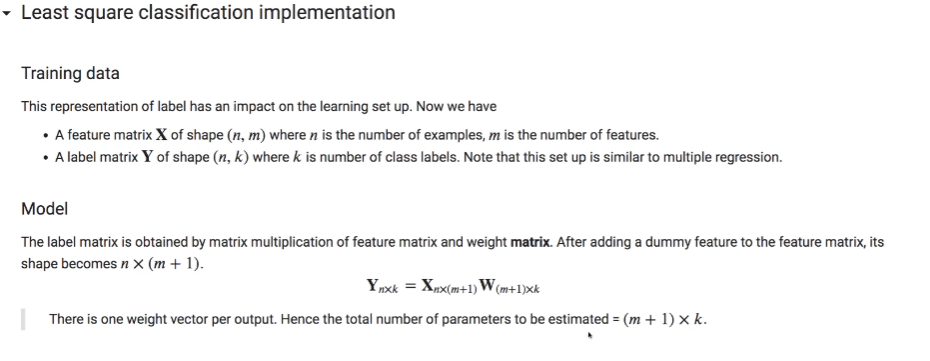

# New Section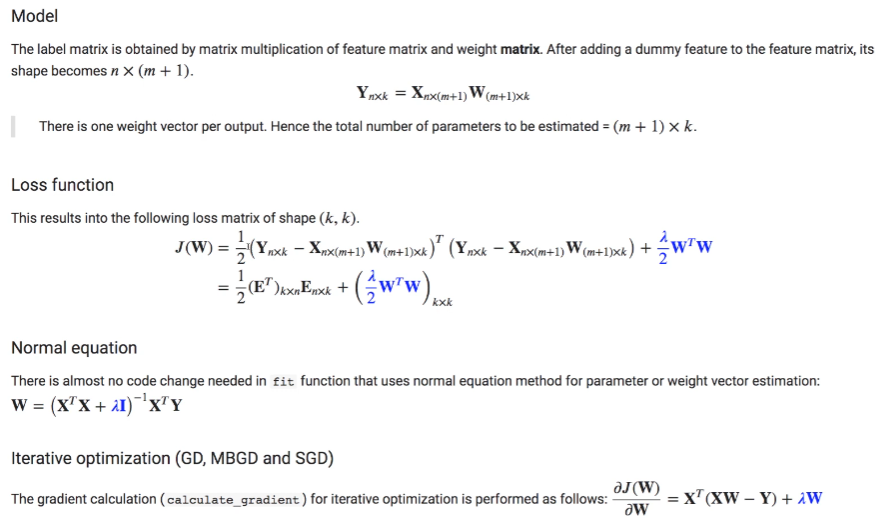

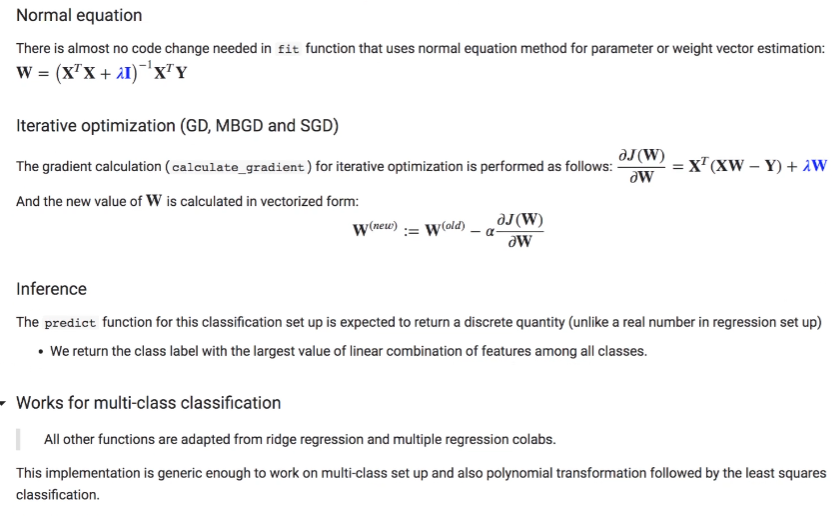

In [ ]:
class LeastSquareClassification(object):
  def __init__(self):
    self.t0=20
    self.t1=1000
  
  def predict(self,X):
    return np.argmax(X @ self.w, axis=-1)

  def predict_internal(self,X):
    return X @ self.w
  
  def loss(self,X,y,reg_rate):
    y_hat = self.predict_internal(X)
    err = y_hat - y
    return (1/2) * (err.T @ err) + (reg_rate / 2) * (self.w.T @ self.w)

  def fit(self,X, y, reg_rate=0):
    self.w = np.linalg.solve(X.T @ X + reg_rate * np.eye(X.shape[-1]), X.T@y)
    print(X.shape, y.shape, self.w.shape)
    return self.w
  
  def calculate_gradient(self, X, y, reg_rate):
    y_hat = self.predict_internal(X)
    return X.T @ (y_hat - y) + reg_rate * self.w
  
  def weight_updates(self, grad,lr):
    return (self.w - lr*grad)
  
  def learning_schedule(self, t):
    return self.t0 / (t + self.t1)
  
  def gd(self, X, y, num_epochs, lr, reg_rate):
    self.w = np.zeros((X.shape[-1], y.shape[-1]))
    self.w_all = []
    self.err_all = []
    for i in np.arange(0, num_epochs):
      djdw = self.calculate_gradient(X, y, reg_rate)
      self.w_all.append(self.w)
      self.err_all.append(self.loss(X, y, reg_rate))
      self.w = self.weight_updates(djdw, lr)
    return self.w
  
  def sgd(self, X, y, num_epochs, reg_rate):
    self.err_all = []
    self.w_all = []
    self.w=np.zeros((X.shape[-1], y.shape[-1]))
    t=0
    for epoch in range(num_epochs):
      for iter in range(X.shape[0]):
        t = t+1
        random_index = np.random.randint(X.shape[0])
        x1 = X[random_index:random_index+1]
        y1 = y[random_index:random_index+1]

        self.w_all.append(self.w)
        self.err_all.append(self.loss(x1, y1, reg_rate))

        djdw = self.calculate_gradient(x1, y1, reg_rate)
        self.w = self.weight_updates(djdw, self.learning_schedule(t))
    return self.w






## Demonstration

We will demonstrate working on least square classification in the following set ups:

1. Linearly separable binary classification set up
2. Linearly separable binary classification set up with a few outliers
3. Multi-class classification with k = 3
4. Polynomial least square classification

Let's create a dataset for binary classification with #samples , n = 50
* It also has the facility to add outliers to the generated dataset
* And it can generate samples from multiple classes(>2)


In [ ]:
## Toy dataset creation
def create_toy_data(add_outliers = False , add_class = False):
  x0 = np.random.normal(size = 50).reshape(-1,2) - 1
  x1 = np.random.normal(size = 50).reshape(-1,2) + 1.
  if add_outliers:
    x_1 = np.random.normal(size = 10).reshape(-1,2) + np.array([5.,10.])
    return np.concatenate([x0, x1, x_1]) , np.concatenate([np.zeros(25), np.ones(30)]).astype(np.int)
  if add_class:
    x2 = np.random.normal(size = 50).reshape(-1,2) + 2.
    return np.concatenate([x0,x1,x2]), np.concatenate([np.zeros(25), np.ones(25), 2 + np.zeros(25)]).astype(np.int)
  return np.concatenate([x0,x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)    


First let's define a generic data preprocessing function that
1. Generates synthetic data by
2. Perform polynomial transformation (default degree = 1) on feature set.

3. Divides the data into training and evaluation sets with train test_split api from sklearn library.
4. Perfoms label transformation for both train and test sets.


In [ ]:
## Dat preprocessing
from sklearn.model_selection import train_test_split

def preprocess(add_class = False , add_outliers = False , degree  = 1):
  x, y = create_toy_data(add_outliers, add_class)
  x_poly  = polynomial_transform(x, degree = degree)
  x_train, x_test, y_train, y_test = train_test_split(x_poly, y)
  y_train_trans = LabelTransformer().encode(y_train)
  y_test_trans = LabelTransformer().encode(y_test)
  return x_train, x_test, y_train, y_test, y_train_trans, y_test_trans

In [ ]:
##@title Model visualization

sns.set_context('notebook', font_scale = 1.5, rc = {'lines.linewidth': 2.5})

def visualize_model(X_train, labels , lsc_obj, degree = 1):

  f = plt.figure(figsize = (8 , 8))

  # compute xlim and ylim

  x1_min = np.min(X_train[:,1])
  x1_max = np.max(X_train[:,1])
  x2_min = np.min(X_train[:,2])
  x2_max = np.max(X_train[:,2])

  x1_test , x2_test = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min , x2_max, 100))
  x_test = np.array([x1_test, x2_test]).reshape(2, -1).T
  x_test_poly = polynomial_transform(x_test ,degree = degree )
  y_test = lsc_obj.predict(x_test_poly)


  sns.scatterplot(data = X_train , x = X_train[:,1], y = X_train[:,2], hue = labels )
  plt.contourf(x1_test, x2_test, y_test.reshape(100, 100), alpha = 0.5, levels = np.linspace(0, 1, 3))

  plt.xlabel("$x_1$")
  plt.ylabel('$x_2$')
  plt.xlim(x1_min , x1_max)
  plt.ylim(x2_min, x2_max)
  plt.gca().set_aspect('equal', adjustable = 'box')
  plt.show()










## Demo 1: Linear separable binary classification

In [ ]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess()

Let's examine the datasets.

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Let's visualize the data

In [ ]:
sns.set_style('white')
f = plt.figure(figsize =(8,8))
sns.set_context('notebook', font_scale = 1.5 , rc = {'lines.linewidth':2.5 })

sns.scatterplot(data = x_train, x = x_train[:,-2] , y =x_train[:,-1] , hue = y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$') 
plt.show()



In [ ]:
lsc = LeastSquareClassification()

### Normal equation

In [ ]:
lsc.fit(x_train, y_train_trans, reg_rate = 0)
print('weight vector', lsc.w)
visualize_model(x_train , y_train , lsc)

In [ ]:
#@ title [Plot learning curves] 
def plot_learning_curve(err_all):
  err = [err[1][1] for err in err_all]
  plt.plot(np.arange(len(err)), err, 'r-')
  plt.xlabel('iter #')
  plt.ylabel('$\mathbf{J(w)}$')

In [ ]:
lsc.sgd(x_train , y_train_trans , num_epochs = 100 ,reg_rate = 0 )
plot_learning_curve(lsc.err_all)

In [ ]:
visualize_model(x_train,y_train,lsc)

### Gradient Descent

In [1]:
lsc = LeastSquareClassification()
lsc.gd(x_train,y_train_trans, num_epochs = 100 , reg_rate = 0 , lr = 1e-3)

NameError: ignored

In [ ]:
plot_learning_curve(lsc.err_all)

In [ ]:
visualize_model(x_train, y_train, lsc)

### Evaluation Metrics

In [ ]:
print(x_test.shape)
y_test_hat = lsc.predict(x_test)

Get counts of true positive and negativs, false positives  and negatives.

In [ ]:
tp = np.where((y_test == 1) & (y_test_hat == 1), 1, 0).sum()#  returns 1 if condition is true else returns zero
tn = np.where((y_test == 0) & (y_test_hat == 0), 1, 0).sum()
fp = np.where((y_test == 0) & (y_test_hat == 1), 1, 0).sum()
fn = np.where((y_test == 1) & (y_test_hat == 0), 1, 0).sum()




In [ ]:
def precision(tp, fp):
  if (tp + fp) == 0: return NaN
  return tp/tp+fp

In [ ]:
def recall(tp, fn):
  if (tp + fn) == 0 :return NaN
  return tp/tp +fn


In [ ]:
def accuracy(tp,tn,fp, fn):
  return(tp + tn)/(tp + tn + fp + fn)

In [ ]:
def f1_score(pr, r):
  return 2*((pr*r)/(pr +r))

### Classification metrics

In [ ]:
pr = precision(tp, fp)
r = recall(tp, fn)
pr, r, accuracy(tp, tn, fp, fn), f1_score(pr, r)

## Demo# 2: Linearly separable binary classification with outliers

In [ ]:
x_train, x_test, y_train,y_test, y_train_trans, y_test_trans =preprocess(add_outliers = True)

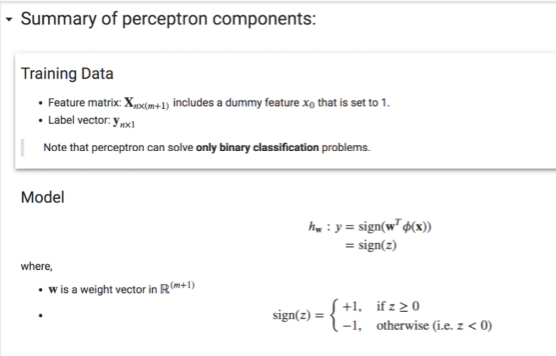

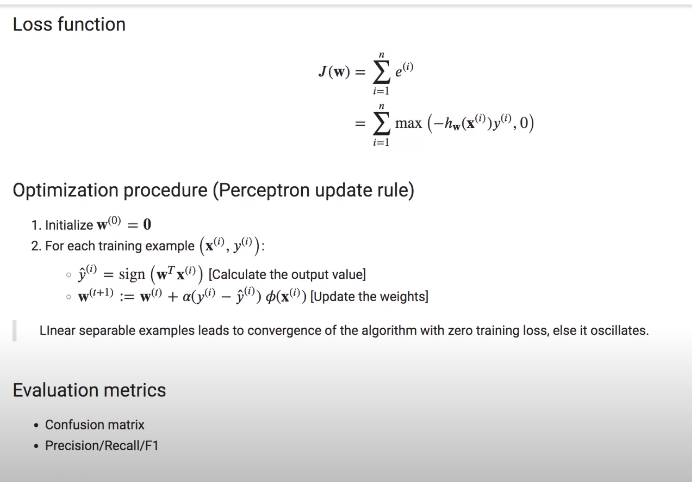

## Implementation


In [ ]:
class perceptron(object):

  def __init__(self):
    return

  def predict(self, X):
    z = X @ self.w
    return np.where( z >= 0 , 1 , -1)  

  def loss(self, X, y):
    return np.sum(np.maximum(-1*predict(X)*y, np.zeros(y.shape[0])))

  def train(self, X, y, num_epochs = 100, lr = 0.001):
    self.w_all = []
    self.err_all = []
    self.w = np.zeros(X.shape[0])

    for _ in range(num_epochs):

      for xi, target in zip(X,y):
        errors = 0
        self.w += lr*(target - predict(xi))*xi
        self.w_ll.append(self.w)
        errors += np.maximum(-1*predict(xi), 0)
        self.err_all.append(errors)
    print()